<a href="https://colab.research.google.com/github/Mostafa-Hamidifard/cvx-optimization/blob/main/hw6_q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
!pip install cvxpy[CBC,CVXOPT,GLOP,GLPK,GUROBI,MOSEK,PDLP,SCIP,XPRESS]
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached cylp-0.91.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.4 MB)
  Using cached PySCIPOpt-4.3.0.tar.gz (665 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ortools-9.4.1874-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.0 MB)
  Using cached xpress-9.1.0-cp310-cp310-manylinux1_x86_64.whl (70.4 MB)
  Using cached Mosek-10.0.40-cp310-cp310-manylinux2014_x86_64.whl (12.4 MB)
  Using cached gurobipy-10.0.1-cp310-cp310-manylinux2014_x86_64.whl (12.7 MB)
  error: subprocess-exited-with-error
  
  × Building wheel for PySCIPOpt (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  

given data

In [81]:
N = 10
n = 100

q = [ (np.exp(-(i-30)**2 / 100 ) + 2*np.exp(-(i-68)**2 / 100)) for i in range(1,101)]
q = np.array(q)
r = np.array([np.exp(-(i - 50)**2 / 100) for i in range(1,101)])

q = q/sum(q)
r = r/sum(r)

solving morph problem using euclidean morphing

In [82]:
def d_squ(u,v):
    return cvx.norm(u-v,2)**2

P = cvx.Variable((n,N)) # each column is a distribution
## constraints
const = []
for i in range(1,N-1):# 1,3,4,...,N-2
    const += [P[:,i:i+1] >= 0]
    const += [(cvx.sum(P[:,i:i+1]) == 1)]
const += [P[:,0] == q]
const += [P[:,N-1] == r]

cost = 0
for i in range(N-1):
    cost += d_squ(P[:,i],P[:,i+1])
objective = cvx.Minimize(cost)
problem = cvx.Problem(objective,const)
problem.solve(solver='ECOS')


0.005327196705954048

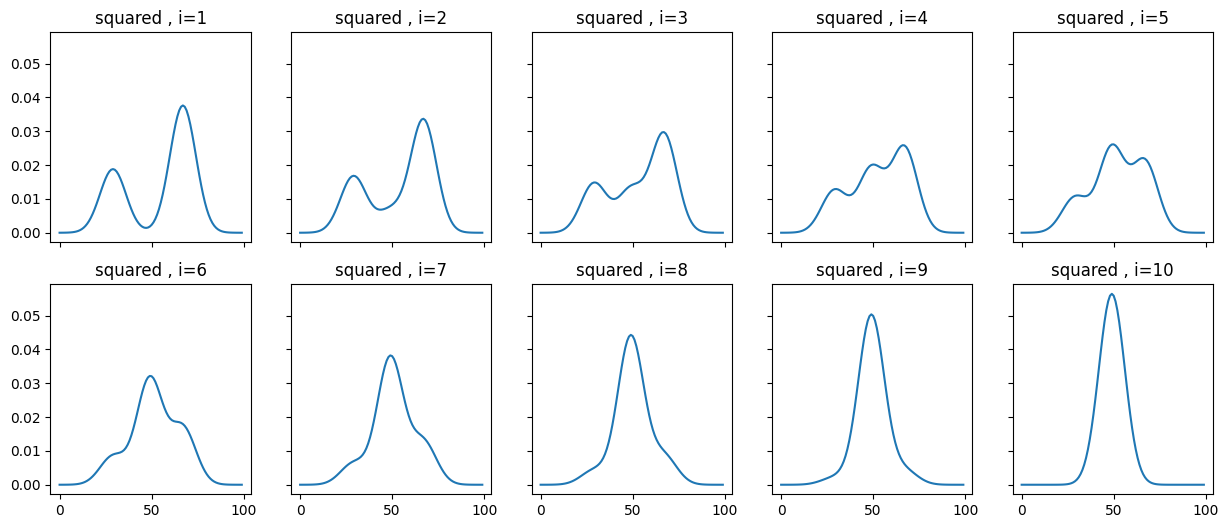

In [83]:
P_opt = P.value
fig , ax = plt.subplots(2,5,figsize=(15,6),sharex=True,sharey=True)

for i in range(N):
    ax[i//5][i%5].plot(P_opt[:,i])
    ax[i//5][i%5].set_title(f"squared , i={i+1}")



solving morph problem using hellinger

In [84]:
def d_hellinger(u,v,t,const):
    c = []
    for j in range(n):
        c += [cvx.bmat([[u[j] , t[j] ],[t[j] , v[j]]]) >> 0]
        # c += [t[j]<= cvx.geo_mean(cvx.hstack([u[j] , v[j]]))]
    const += c
    return cvx.sum(u) + cvx.sum(v) - 2* cvx.sum(t)

T = cvx.Variable((n,N-1))
P = cvx.Variable((n,N)) # each column is a distribution
## constraints
const = []
for i in range(1,N-1):# 1,3,4,...,N-2
    const += [P[:,i:i+1] >= 0]
    const += [(cvx.sum(P[:,i:i+1]) == 1)]
const += [P[:,0] == q]
const += [P[:,N-1] == r]

cost = 0
for i in range(N-1):
    cost += d_hellinger(P[:,i],P[:,i+1],T[:,i],const)

objective = cvx.Minimize(cost)
problem = cvx.Problem(objective,const)
problem.solve(solver='SCS')


0.11209010111214468

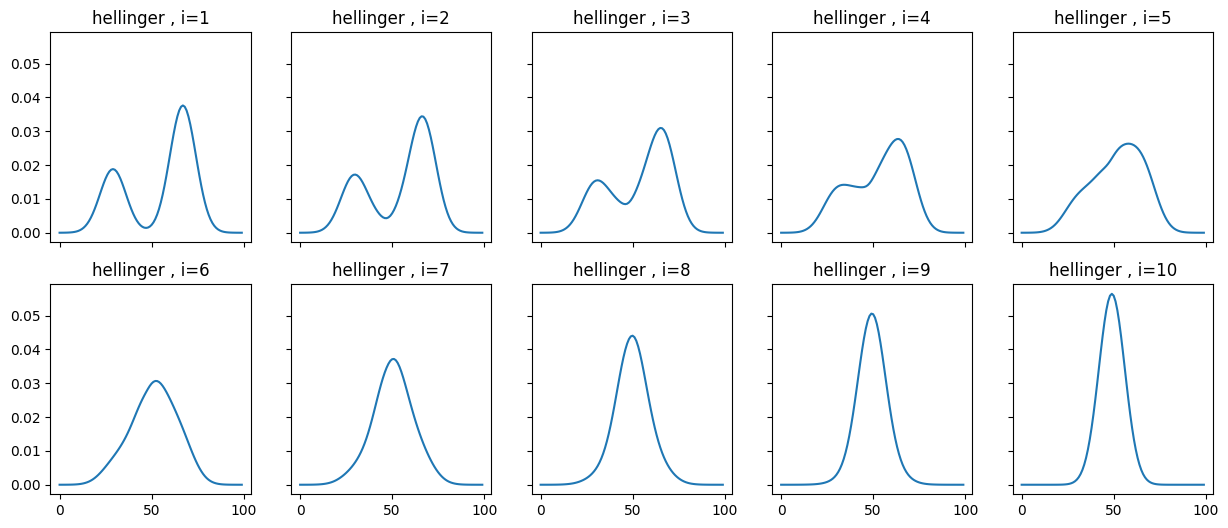

In [85]:
P_opt = P.value
fig , ax = plt.subplots(2,5,figsize=(15,6),sharex=True,sharey=True)
for i in range(N):
    ax[i//5][i%5].plot(P_opt[:,i])
    ax[i//5][i%5].set_title(f"hellinger , i={i+1}")

solving morphing problem using Kolmogrov distance
## this version is implemented using same formula in problem

In [86]:
def d_kol_extra_const(u,v,t,const):
    c = []
    diff = cvx.cumsum(u) - cvx.cumsum(v)
    c += [cvx.max(cvx.abs(diff))-t<=0]
    const += c
    
T = cvx.Variable((N-1,1))
P = cvx.Variable((n,N)) # each column is a distribution
## constraints
const = []
for i in range(1,N-1):# 1,3,4,...,N-2
    const += [P[:,i:i+1] >= 0]
    const += [(cvx.sum(P[:,i:i+1]) == 1)]


const += [P[:,0] == q]
const += [P[:,N-1] == r]

cost = 0
for i in range(N-1):
    diff = cvx.cumsum(P[:,i:i+1]) - cvx.cumsum(P[:,i+1:i+2])
    cvx.max(cvx.abs(diff))
    cost +=  cvx.max(cvx.abs(diff))

objective = cvx.Minimize(cost)
problem = cvx.Problem(objective,const)
problem.solve(solver='ECOS')

0.501906208099679

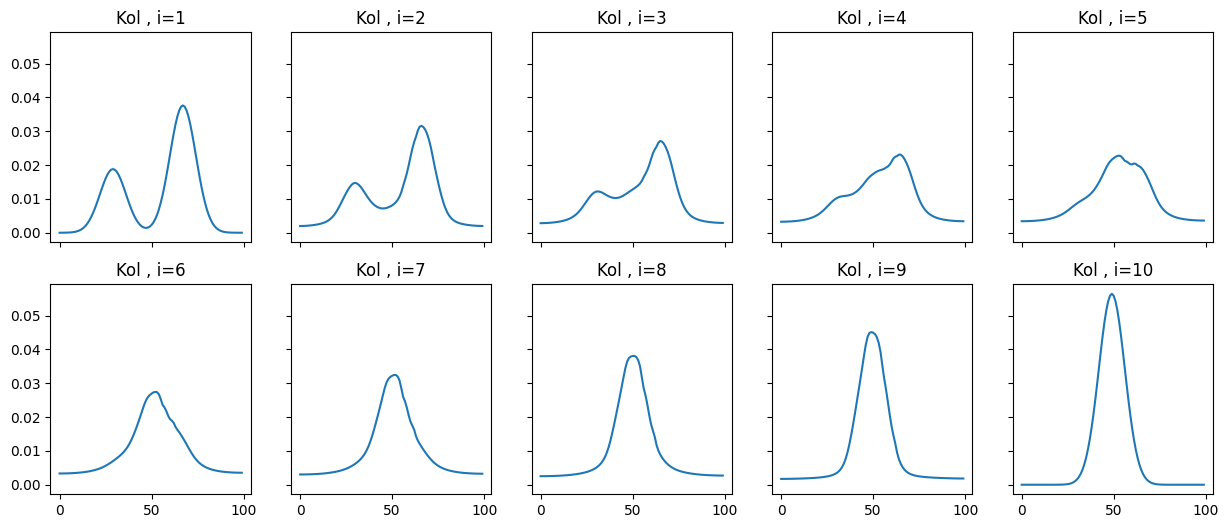

In [87]:
P_opt = P.value
fig , ax = plt.subplots(2,5,figsize=(15,6),sharex=True,sharey=True)
for i in range(N):
    ax[i//5][i%5].plot(P_opt[:,i])
    ax[i//5][i%5].set_title(f"Kol , i={i+1}")

solving morphing problem using Kolmogrov distance
## this version is implemented using LP

In [88]:
def d_kol_extra_const(u,v,t,const):
    c = []
    diff = cvx.cumsum(u) - cvx.cumsum(v)
    c += [diff-t<=0 , diff+t>=0]
    const += c
    
T = cvx.Variable((N-1,1))
P = cvx.Variable((n,N)) # each column is a distribution
## constraints
const = []
for i in range(1,N-1):# 1,3,4,...,N-2
    const += [P[:,i:i+1] >= 0]
    const += [(cvx.sum(P[:,i:i+1]) == 1)]

for k in range(N-1):
    d_kol_extra_const(P[:,k:k+1],P[:,k+1:k+2],T[k],const)

const += [P[:,0] == q]
const += [P[:,N-1] == r]

cost = cvx.sum(T)

objective = cvx.Minimize(cost)
problem = cvx.Problem(objective,const)
problem.solve(solver='ECOS')

0.5019062080986463